In [89]:
import matplotlib.pyplot as plt
import torch
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
df_orig, metadata = nnts.data.load("electricity")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()
model_name = "seg-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [107]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )


In [52]:
for scenario in scenario_list:
    metadata.context_length = metadata.prediction_length * 3 + 1
    params.batches_per_epoch = 500
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.SegLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
        metadata.seasonality
        
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(12, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=12, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 254.38026428222656, 'valid_loss': 254.1553192138672, 'elapsed_time': 0.49886162485927343}
Artifact saved to results/seg-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 217.3811492919922, 'valid_loss': 168.8119354248047, 'elapsed_time': 0.5123926671221852}
Artifact saved to results/seg-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 108.43656921386719, 'valid_loss': 25.000289916992188, 'elapsed_time': 0.4980584168806672}
{'train_loss': 70.00495147705078, 'valid_loss': 27.330217361450195, 'elapsed_time': 0.5143162910826504}
Artifact saved to results/seg-lstm/

In [108]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [109]:
import seaborn as sns
sns.set()

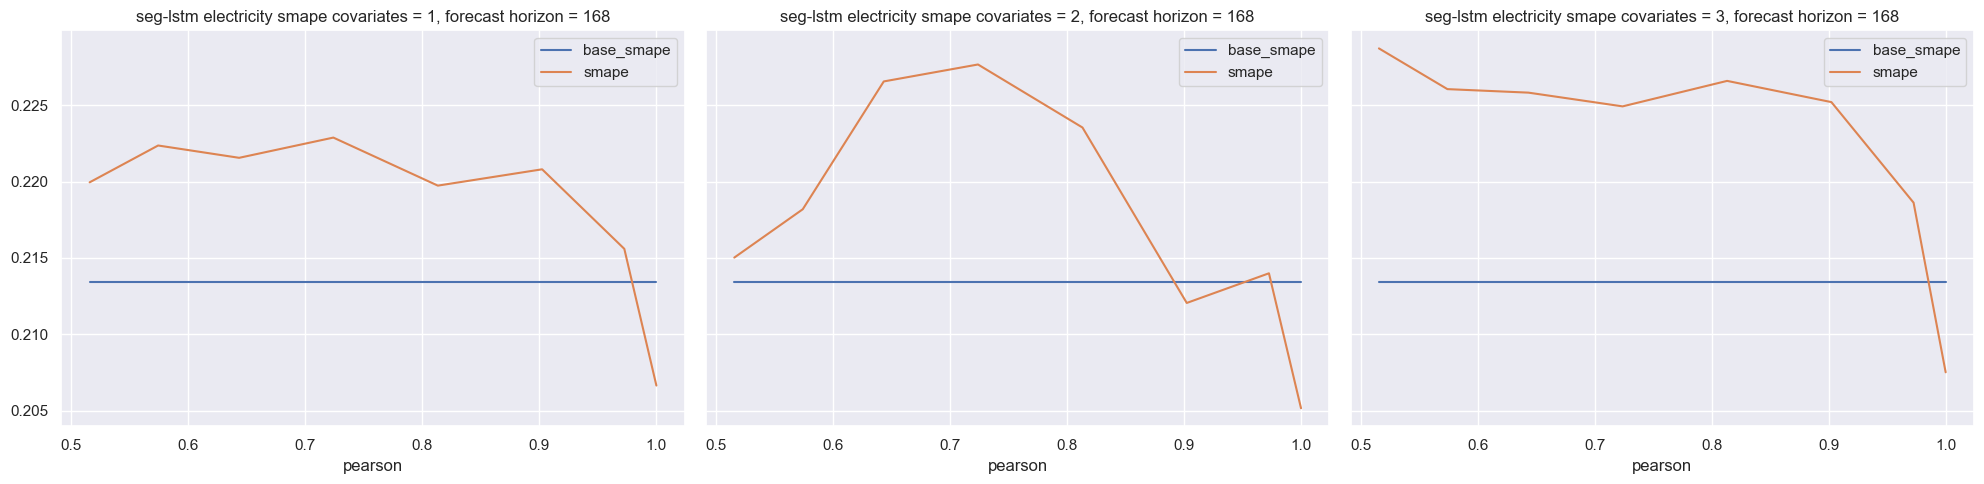

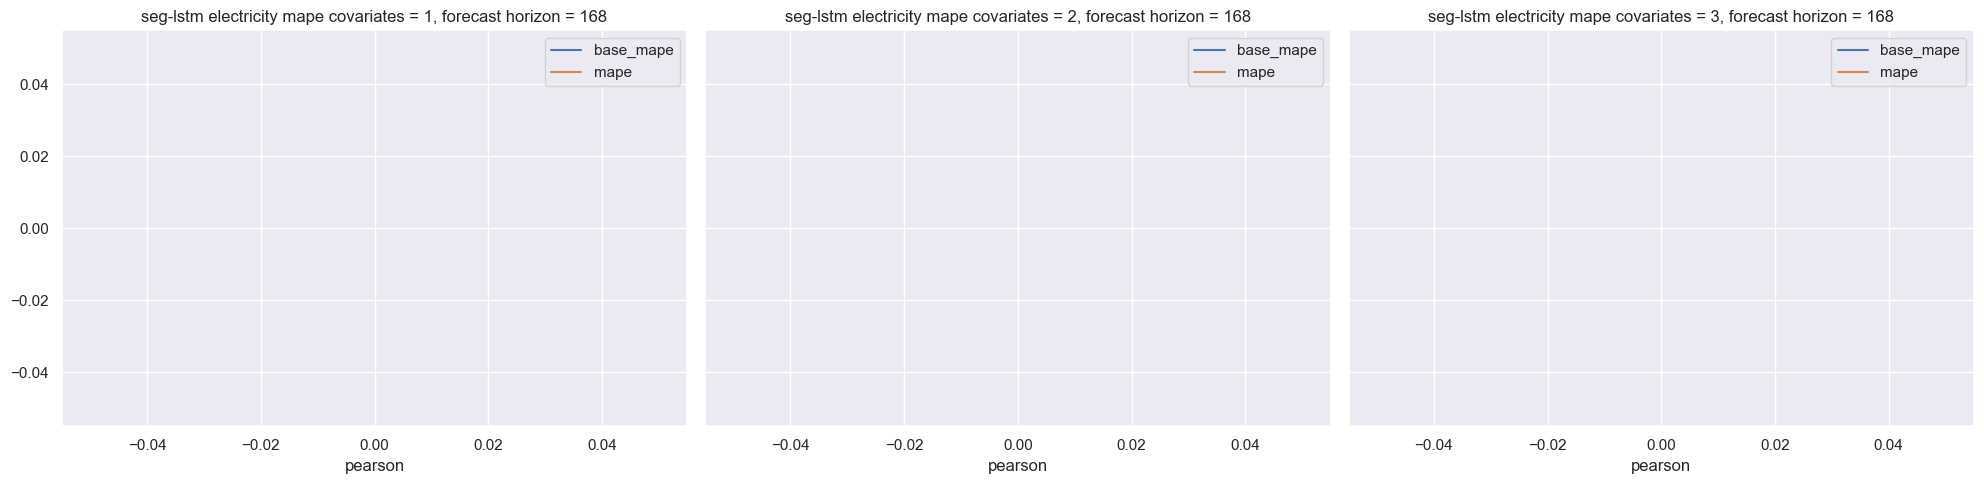

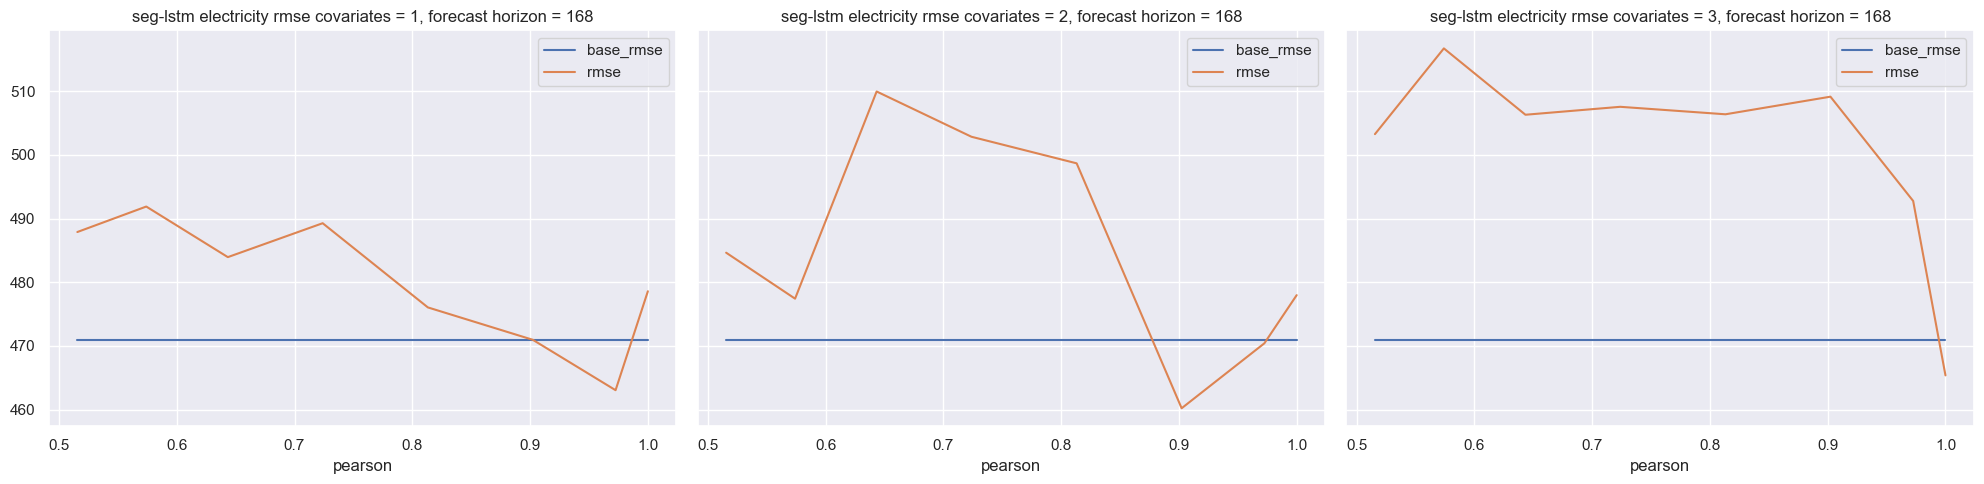

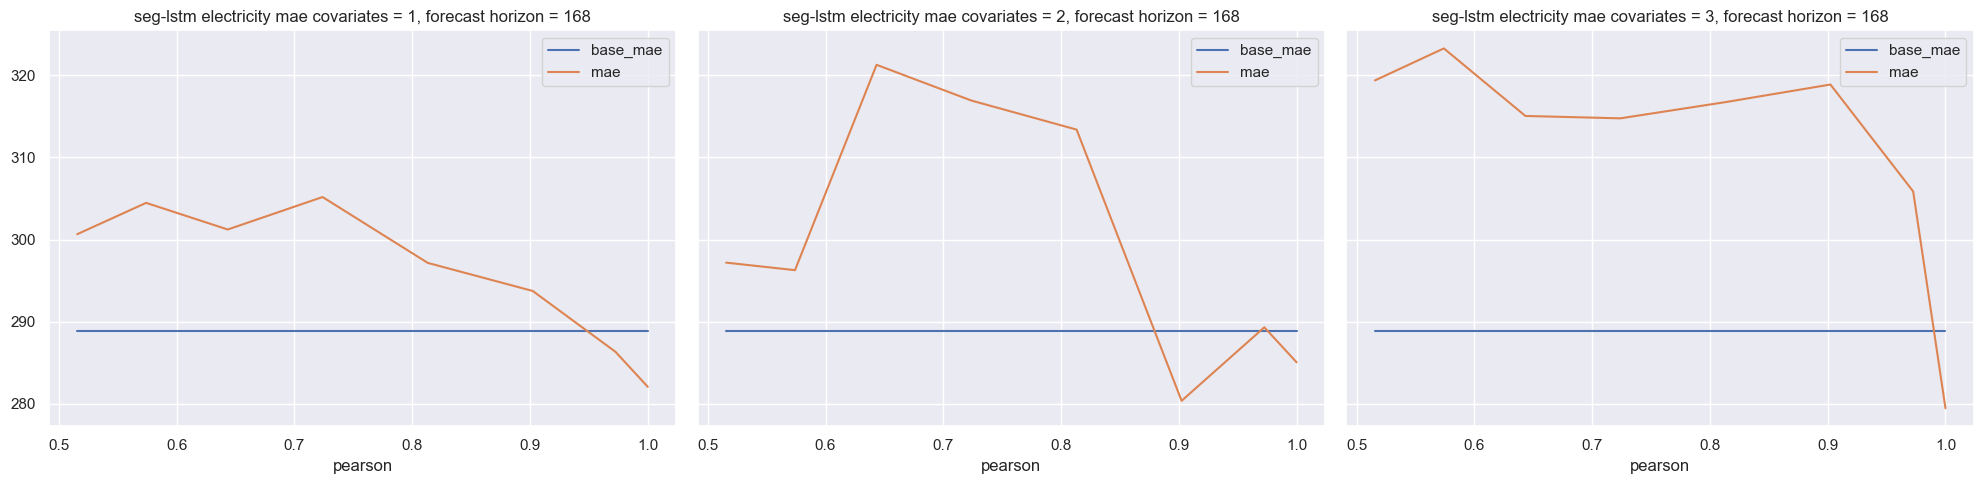

In [110]:
results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse", "mae"]:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=True)
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[0],
        title=f"{model_name} {metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1],
        title=f"{model_name} {metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[2],
        title=f"{model_name} {metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")

/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

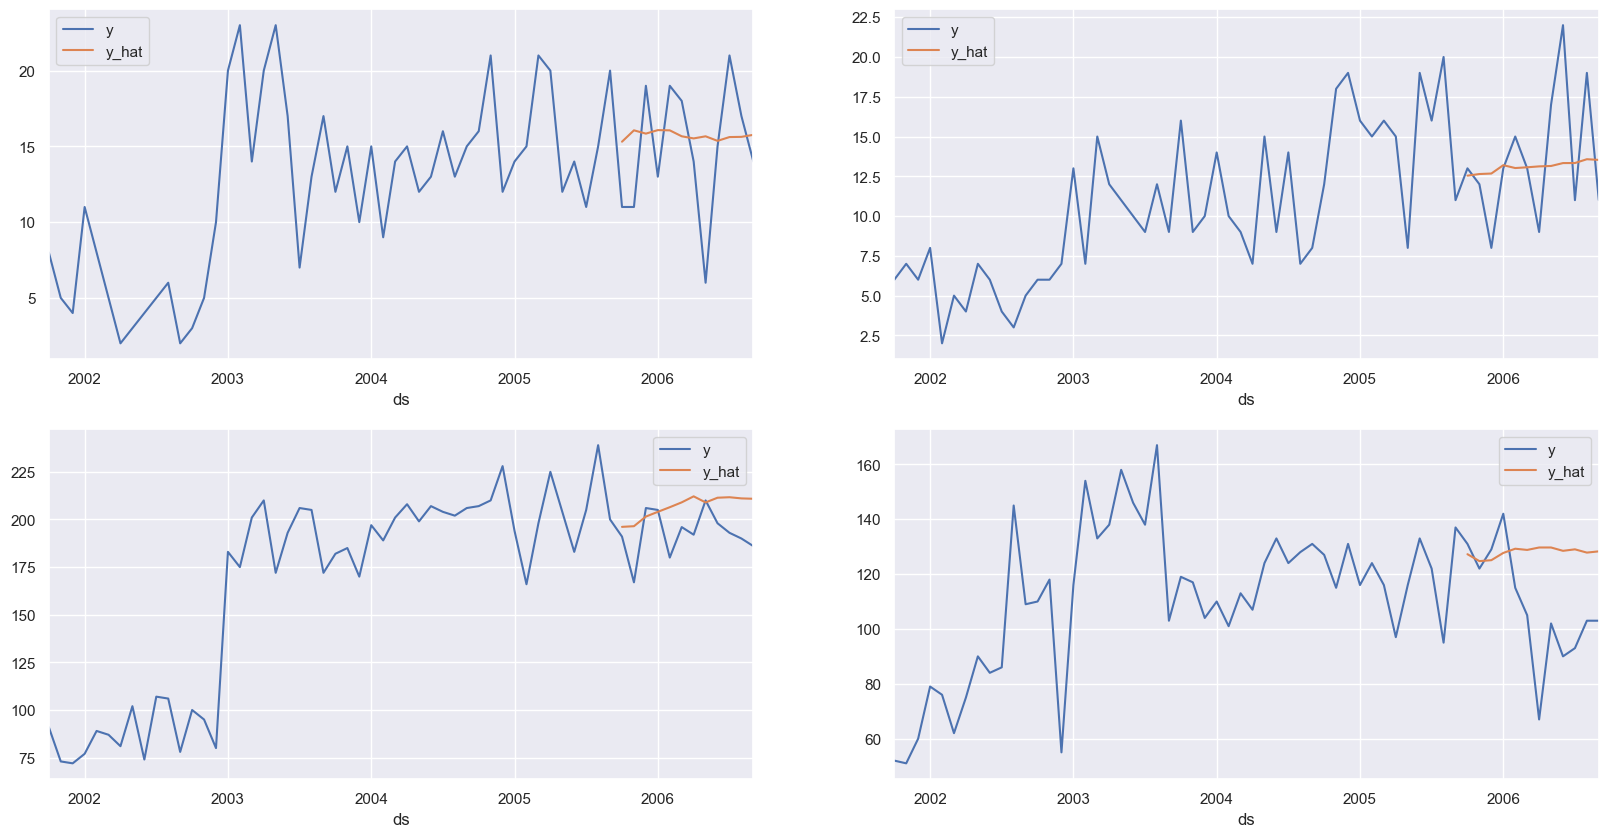

In [56]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [111]:
univariate_results = results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(smape      0.212022
 mape            inf
 rmse     469.076904
 mae      287.952765
 dtype: float64,
 smape    0.002647
 mape          NaN
 rmse     8.822975
 mae      6.691691
 dtype: float64,
 smape    5
 mape     5
 rmse     5
 mae      5
 dtype: int64)

In [112]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [113]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

,dataset,error,pearson,covariates,prediction_length,smape
23,electricity,0.000000,1.000000,1,168,0.206646
2,electricity,0.471429,0.902327,1,168,0.220799
12,electricity,1.650000,0.515570,1,168,0.219947
0,electricity,0.000000,1.000000,2,168,0.205159
22,electricity,0.471429,0.902327,2,168,0.212051
7,electricity,1.650000,0.515570,2,168,0.215021
9,electricity,0.000000,1.000000,3,168,0.207514
15,electricity,0.471429,0.902327,3,168,0.225197
24,electricity,1.650000,0.515570,3,168,0.228712


In [104]:
sorted(results["error"].unique().tolist())

[0.0,
 0.2357142857142857,
 0.4714285714285714,
 0.7071428571428571,
 0.9428571428571428,
 1.1785714285714286,
 1.414285714285714,
 1.65]